In [1]:
%load_ext autoreload
%autoreload 2

In [118]:
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import torch
from torch.distributions import MixtureSameFamily, MultivariateNormal, Categorical
from IPython import display

from distillation.networks.mlp import MLPUNetTimesCond, MLPUNet, MLPUNetTimeCond
from distillation.algorithms.ddib import DDIB
from distillation.data.bidimensional import Checkerboard
from distillation.algorithms.base import SamplingMethod

In [8]:
class MixGauss1:
    def __init__(self, batch_size):
        self.batch_size = batch_size
        means = torch.tensor([[0.0, 0.0], [1.0, 1.0], [4.5, -2.0]])
        covs = torch.stack([torch.eye(2), torch.eye(2), torch.eye(2)], dim=0) / 50
        self.distribution = MixtureSameFamily(
            mixture_distribution=Categorical(probs=torch.tensor([0.333, 0.333, 0.333])),
            component_distribution=MultivariateNormal(means, covs)
        )
    def sample(self):
        return self.distribution.sample(sample_shape=(self.batch_size, ))
    def get_dataloader(self):
        while True:
            yield self.sample()

class MixGauss2:
    def __init__(self, batch_size):
        self.batch_size = batch_size
        means = torch.tensor([[4.0, 0.0], [5.0, 1.0], [4.5, 2.0]])
        covs = torch.stack([torch.eye(2), torch.eye(2), torch.eye(2)], dim=0) / 50
        self.distribution = MixtureSameFamily(
            mixture_distribution=Categorical(probs=torch.tensor([0.333, 0.333, 0.333])),
            component_distribution=MultivariateNormal(means, covs)
        )
    def sample(self):
        return self.distribution.sample(sample_shape=(self.batch_size, ))
    def get_dataloader(self):
        while True:
            yield self.sample()

### DDIB

In [116]:
dset1 = MixGauss1(1024)
dl1 = dset1.get_dataloader()
dset2 = Checkerboard(1024)
dl2 = dset2.get_dataloader()
device = "cpu"

In [117]:
mlp1 = MLPUNetTimeCond(data_dim=2, n_layers=3, n_channels=128, act=torch.nn.SiLU(), norm=None)
mlp2 = MLPUNetTimeCond(data_dim=2, n_layers=3, n_channels=128, act=torch.nn.SiLU(), norm=None)
ddib = DDIB(noisy_model=mlp1, clean_model=mlp2, lr=1e-3, seed=42)

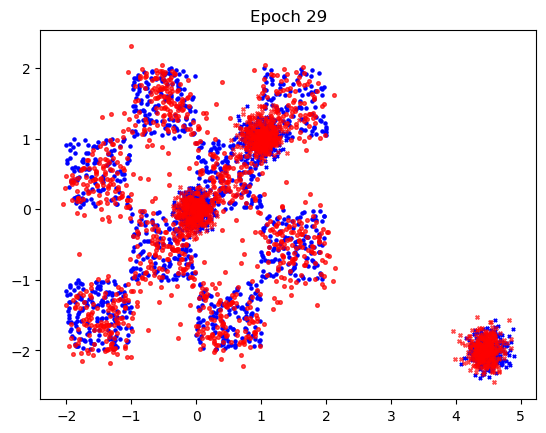

In [119]:
fig, ax = plt.subplots()
hdisplay = display.display(fig, display_id=True)
target1 = next(dl1)
target2 = next(dl2)
sampling_rng = torch.Generator(device=device)

for i in range(30):
    ddib.train_noisy(dl1, n_steps=100, device=device)
    ddib.train_clean(dl2, n_steps=100, device=device)

    noisy_samples = ddib.sample_noisy(n_steps=20, sample_size=(1024, 2), device=device, rng=sampling_rng, sampling_method=SamplingMethod.HEUN)
    clean_samples = ddib.sample_clean(n_steps=20, sample_size=(1024, 2), device=device, rng=sampling_rng, sampling_method=SamplingMethod.HEUN)

    ax.clear()
    ax.scatter(target1[:, 0], target1[:, 1], c='b', marker='x', s=5)
    ax.scatter(target2[:, 0], target2[:, 1], c='b', marker='o', s=5)
    ax.scatter(noisy_samples[-1][:, 0], noisy_samples[-1][:, 1], c='r', marker='x', s=7, alpha=0.7)
    ax.scatter(clean_samples[-1][:, 0], clean_samples[-1][:, 1], c='r', marker='o', s=7, alpha=0.7)
    ax.set_title(f"Epoch {i}")
    hdisplay.update(fig)
plt.close(fig)

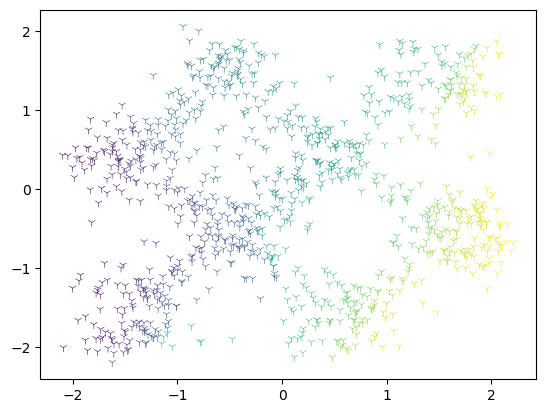

In [121]:
n_steps = 100
source = next(dl1)
batch_size = len(source)
color_index = torch.argsort(source[:, 0], dim=0)
sorted_source = source[torch.sort(source[:, 0], dim=0).indices]
restored = ddib.restore(sorted_source, n_steps=n_steps, device=device, sampling_method=SamplingMethod.HEUN)
fig, ax = plt.subplots()
color = list(range(batch_size))
# ax.scatter(sorted_source[:, 0], sorted_source[:, 1], c=color, s=40, marker="2", linewidths=0.4)
# ax.scatter(restored[n_steps][:, 0], restored[n_steps][:, 1], c=color, s=30, alpha=0.3, marker='8', edgecolor='none')
ax.scatter(restored[-1][:, 0], restored[-1][:, 1], c=color, s=40, marker='1', linewidths=0.4)